In [29]:
import pandas as pd
import mne_bids
import matplotlib
import mne
import numpy as np
from wordfreq import zipf_frequency

In [30]:
def segment(raw):
    # preproc annotations
    meta = list()
    for annot in raw.annotations:
        d = eval(annot.pop("description"))
        for k, v in annot.items():
            assert k not in d.keys()
            d[k] = v
        meta.append(d)
    meta = pd.DataFrame(meta)
    meta["intercept"] = 1.0

    # compute voicing
    phonemes = meta.query('kind=="phoneme"')
    assert len(phonemes)
    for ph, d in phonemes.groupby("phoneme"):
        ph = ph.split("_")[0]
        match = ph_info.query("phoneme==@ph")
        assert len(match) == 1
        meta.loc[d.index, "voiced"] = match.iloc[0].phonation == "v"

    # compute word frquency and merge w/ phoneme
    meta["is_word"] = False
    words = meta.query('kind=="word"').copy()
    assert len(words) > 10
    # assert np.all(meta.loc[words.index + 1, "kind"] == "phoneme")
    meta.loc[words.index + 1, "is_word"] = True
    wfreq = lambda x: zipf_frequency(x, "en")  # noqa
    meta.loc[words.index + 1, "wordfreq"] = words.word.apply(wfreq).values

    meta = meta.query('kind=="phoneme"')
    assert len(meta.wordfreq.unique()) > 2

    # segment
    events = np.c_[
        meta.onset * raw.info["sfreq"], np.ones((len(meta), 2))
    ].astype(int)

    epochs = mne.Epochs(
        raw,
        events,
        tmin=-0.200,
        tmax=0.6,
        decim=10,
        baseline=(-0.2, 0.0),
        metadata=meta,
        preload=True,
        event_repeated="drop",
    )

    # threshold
    th = np.percentile(np.abs(epochs._data), 95)
    epochs._data[:] = np.clip(epochs._data, -th, th)
    epochs.apply_baseline()
    th = np.percentile(np.abs(epochs._data), 95)
    epochs._data[:] = np.clip(epochs._data, -th, th)
    epochs.apply_baseline()
    return epochs

In [31]:
import mne_bids
session='0'
task='0'
bids_path = mne_bids.BIDSPath(
subject='01',
session='1',
task='0',
datatype="meg",
root='',
)

In [32]:
raw = mne_bids.read_raw_bids(bids_path)

Extracting SQD Parameters from sub-01/ses-1/meg/sub-01_ses-1_task-0_meg.con...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Ready.
Reading events from sub-01/ses-1/meg/sub-01_ses-1_task-0_events.tsv.
Reading channel info from sub-01/ses-1/meg/sub-01_ses-1_task-0_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.


/var/folders/40/zc_tdzg525db497ys8y_9gz40000gn/T/ipykernel_7212/3316973082.py:1: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


In [33]:
raw.get_data().shape

(256, 460000)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)


/Users/anubhavsarkar/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


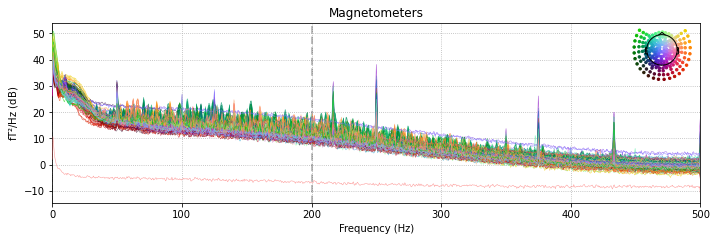

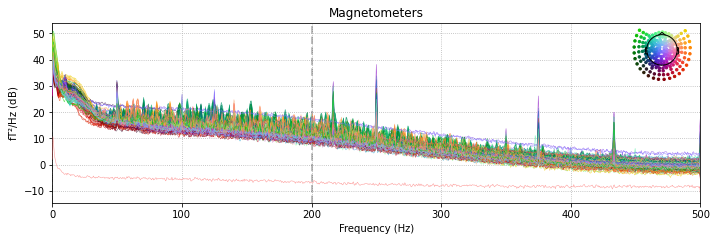

In [34]:
raw.plot_psd()

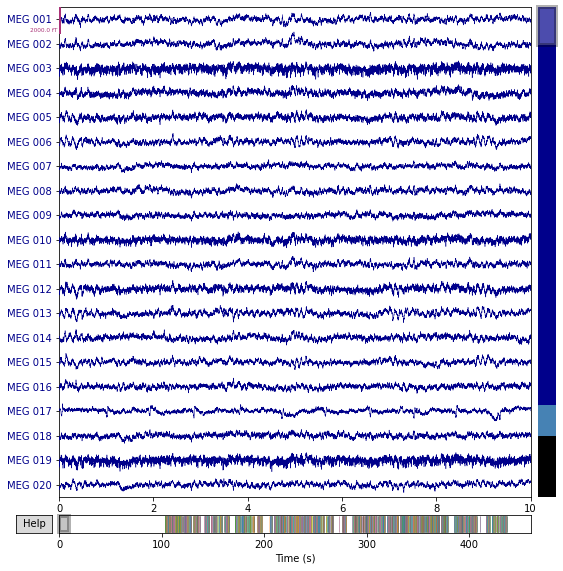

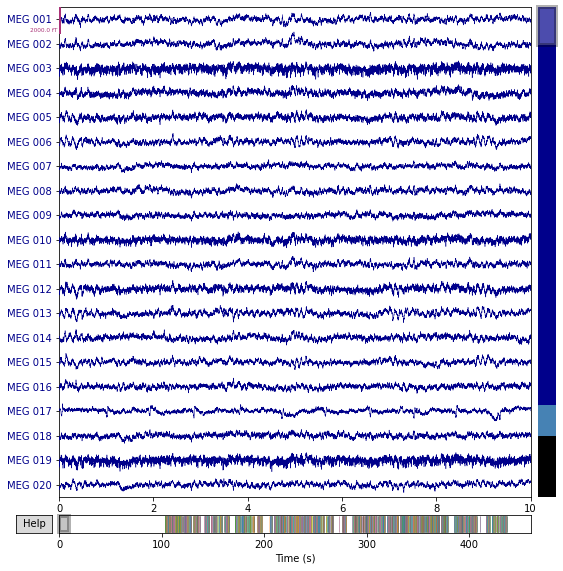

In [35]:
raw.plot()

In [36]:
raw.load_data().filter(0.5, 30.0, n_jobs=1)

Reading 0 ... 459999  =      0.000 ...   459.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)



<RawKIT | sub-01_ses-1_task-0_meg.con, 256 x 460000 (460.0 s), ~898.7 MB, data loaded>

In [37]:
raw = raw.pick_types(
    meg=True, misc=False, eeg=False, eog=False, ecg=False
)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [38]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica

Fitting ICA to data using 208 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 27.4s.


<ICA | raw data decomposition, method: fastica (fit in 42 iterations on 460000 samples), 20 ICA components (208 PCA components available), channel types: mag, no sources marked for exclusion>

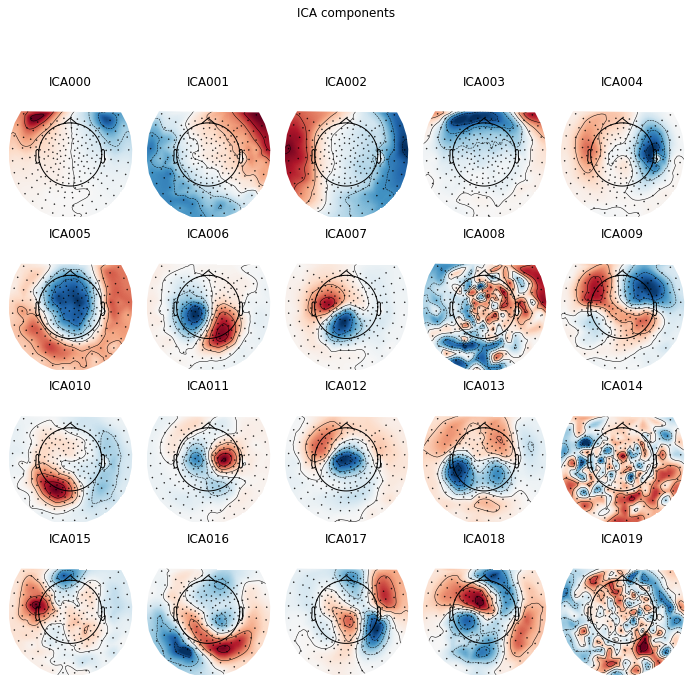

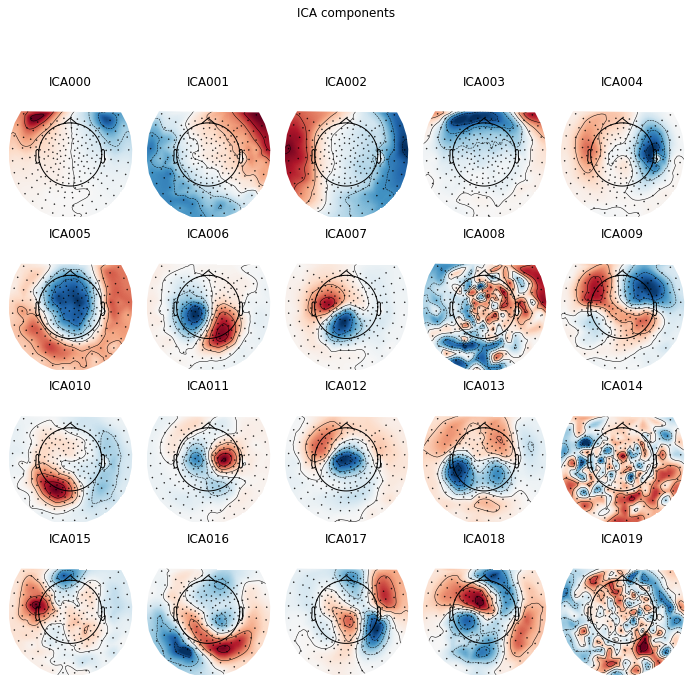

In [45]:
ica.plot_components()

In [40]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = [
    "MEG 001",
    "MEG 002",
    "MEG 003",
    "MEG 004",
    "MEG 005",
    "MEG 006",
    "MEG 007",
    "MEG 008",
    "MEG 009",
    "MEG 010",
    "MEG 011",
    "MEG 012",
    "MEG 013",
    "MEG 014",
    "MEG 015",
    "MEG 016",
    "MEG 017",
    "MEG 018",
    "MEG 019",
    "MEG 020",
]
chan_idxs = [raw.ch_names.index(ch) for ch in chs]


Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 208 PCA components


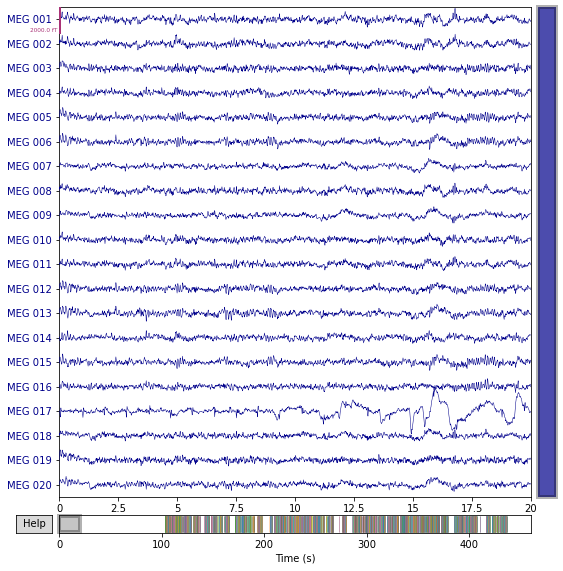

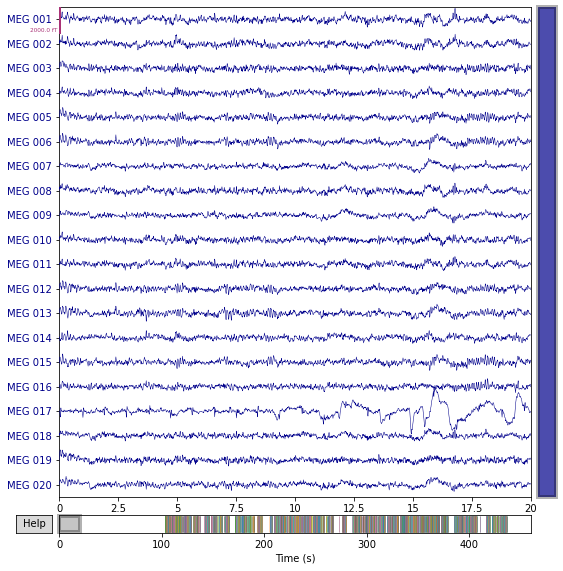

In [41]:

orig_raw.plot(order=chan_idxs, start=0, duration=20)


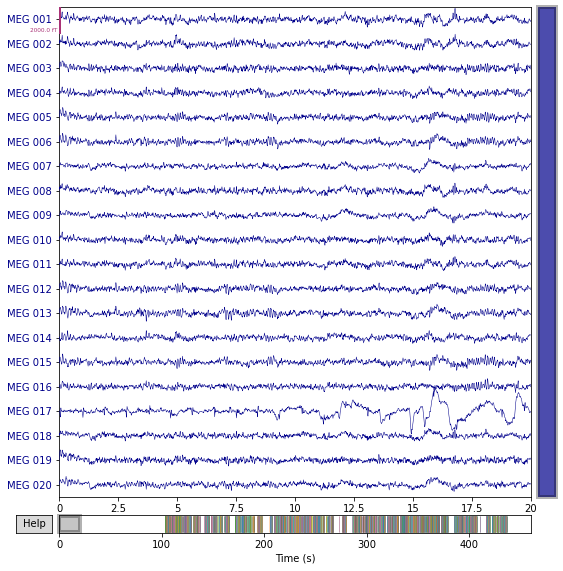

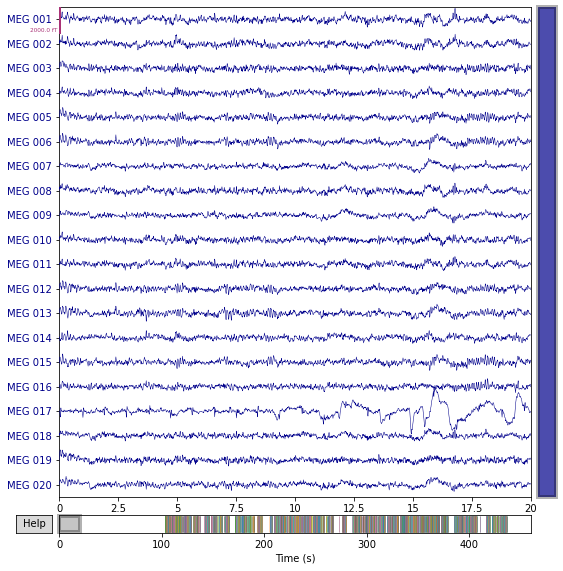

In [42]:

raw.plot(order=chan_idxs, start=0, duration=20)

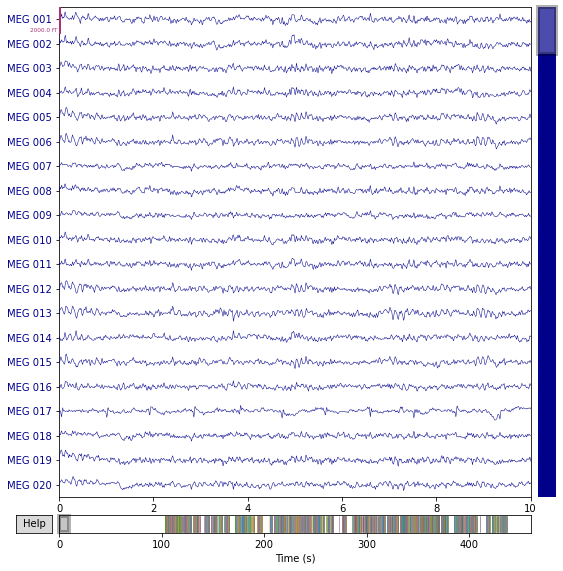

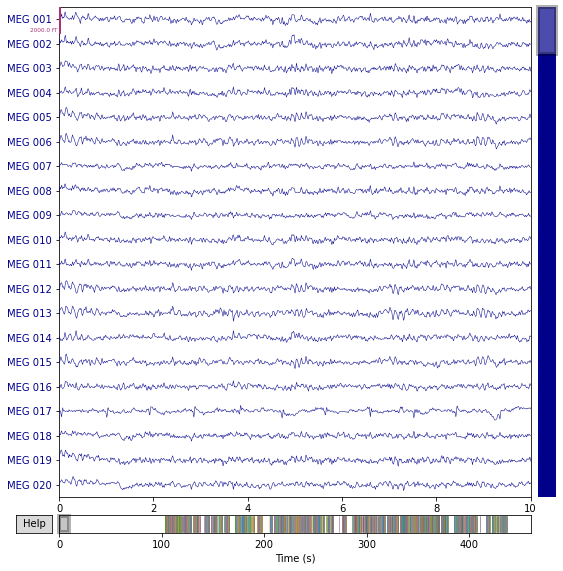

In [64]:
raw.plot()

In [ ]:
raw.

In [50]:
ph_info = pd.read_csv("phoneme_info.csv")

In [51]:
epochs = segment(raw)

Adding metadata with 21 columns
2462 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2462 events and 801 original time points (prior to decimation) ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


In [52]:
epochs.metadata["half"] = np.round(
    np.linspace(0, 1.0, len(epochs))
).astype(int)

In [53]:
epochs.metadata["task"] = task

In [54]:
epochs.metadata["session"] = session

In [55]:
for epoch in epochs[:len(epochs)]:
    for e in epoch[:len(epoch)]:
        for es in e[:1]:
            break
print(len(e))
print(len(epoch))
print(len(epochs))

81
208
2462


In [57]:
epochs

<Epochs |  2462 events (all good), -0.2 – 0.6 s, baseline -0.2 – 0 s, ~316.7 MB, data loaded, with metadata,
 '1': 2462>

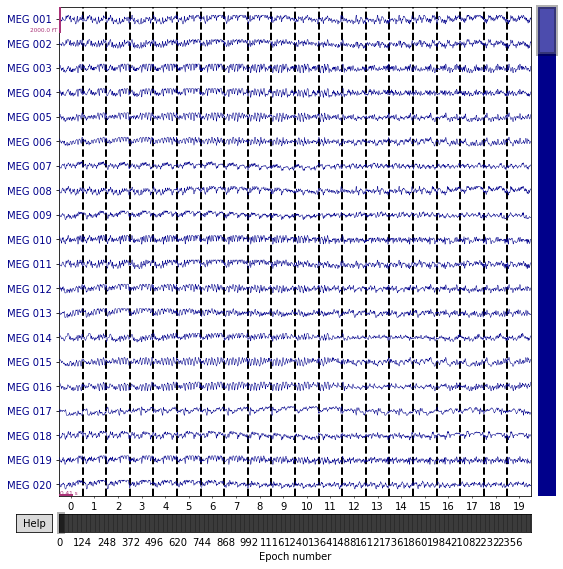

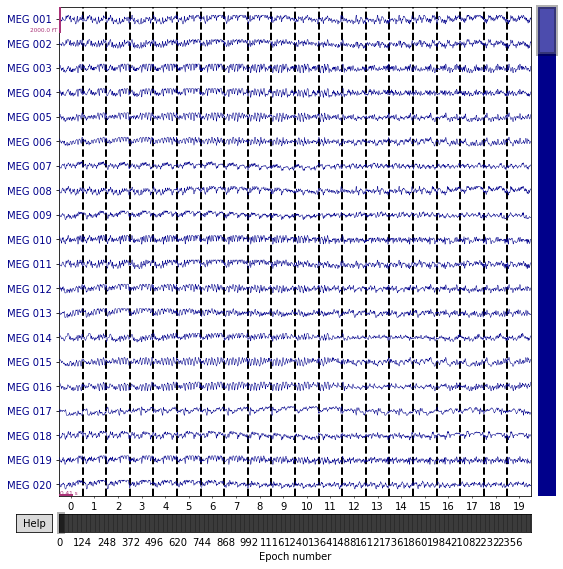

In [58]:
epochs.plot()

Not setting metadata
2462 matching events found
No baseline correction applied
0 projection items activated


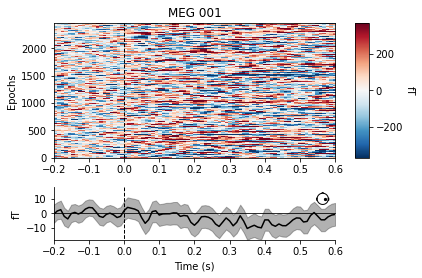

[<Figure size 432x288 with 4 Axes>]

In [59]:
epochs.plot_image(picks=["MEG 001"])

In [60]:
epochs = epochs.average()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [61]:
epochs

<Evoked | '1' (average, N=2462), -0.2 – 0.6 s, baseline -0.2 – 0 s, 208 ch, ~332 kB>

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


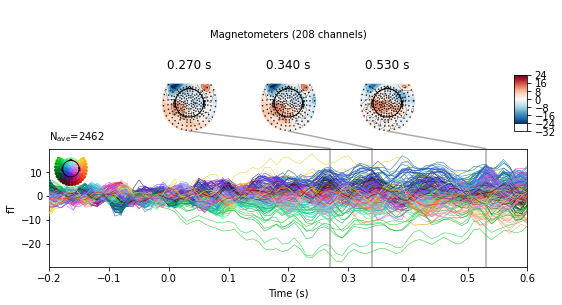

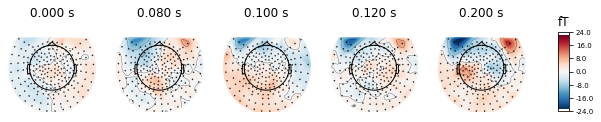

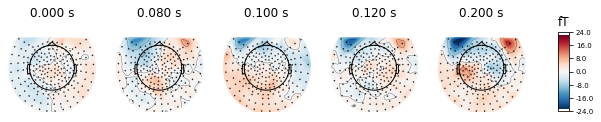

In [62]:
epochs.plot_joint(picks="meg")
epochs.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="mag")

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


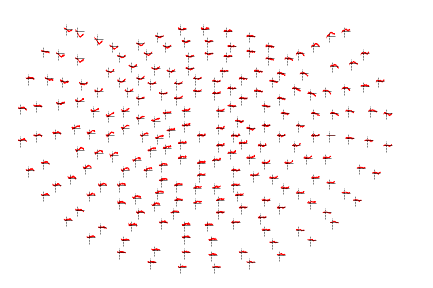

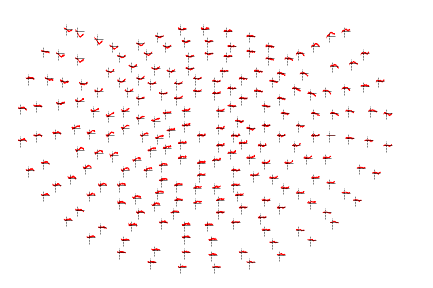

In [63]:
epochs.pick_types(meg="mag").plot_topo(color="r", legend=False)

In [ ]:
df = raw.annotations.to_data_frame()

In [ ]:
df = pd.DataFrame(df.description.apply(eval).to_list())
df